<a href="https://colab.research.google.com/github/gkckdals3/ML_/blob/main/cow_instance_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### MMDetection 설치

In [20]:
!pip install mmcv-full -f !pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html

!git clone https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

Looking in links: !pip, https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
fatal: destination path 'mmdetection' already exists and is not an empty directory.
running install
running bdist_egg
running egg_info
writing mmdet.egg-info/PKG-INFO
writing dependency_links to mmdet.egg-info/dependency_links.txt
writing requirements to mmdet.egg-info/requires.txt
writing top-level names to mmdet.egg-info/top_level.txt
reading manifest template 'MANIFEST.in'
adding license file 'LICENSE'
writing manifest file 'mmdet.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mmdet
creating build/bdist.linux-x86_64/egg/mmdet/datasets
copying build/lib/mmdet/datasets/wider_face.py -> build/bdist.linux-x86_64/egg/mmdet/datasets
copying build/lib/mmdet/datasets/xml_style.py -> build/bdist.linux-x86_64/egg/mmdet/datasets
copying build/lib/mmdet/dataset

In [1]:
# 런타임->런타임 다시 시작 후 아래 수행. 
\
import mmcv

In [2]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.10.0+cu111 (Tesla P100-PCIE-16GB)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
import json

with open('/content/drive/MyDrive/train_answer2.json') as json_file:
    data_infos = json.load(json_file)

print(data_infos)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [80]:
import os.path as osp
import json
from tqdm.notebook import tqdm
import cv2
# json에 카테고리 내용 추가
data_infos['categories']=[]
data_infos['categories'].append({"id": 1, "name":"cow"})
data_infos['categories'].append({"id": 2, "name":"crazycow"})
coco_format_json = dict(
      images = images,
      annotations = annotations,
      categories = categories
)

  # json 파일로 출력. 
  #mmcv.dump(coco_format_json, out_file)
with open('/content/drive/MyDrive/train_images/coco_train', 'w') as json_out_file:
  json.dump(coco_format_json, json_out_file)
    

In [27]:
from pycocotools.coco import COCO

coco=COCO('/content/drive/MyDrive/train_answer2.json')

loading annotations into memory...
Done (t=0.55s)
creating index...
index created!


In [22]:
# image id 0번에 대한 image 정보와 해당 image의 object별 정보 추출. 
img = coco.loadImgs(1)[0]
print(img)
annIds = coco.getAnnIds(imgIds=img['id'], catIds=[1], iscrowd=None)
anns = coco.loadAnns(annIds)
print(coco.getCatIds)
print(anns)

{'file_name': 'train_0001.PNG', 'width': 1282, 'height': 720, 'id': 1}
<bound method COCO.getCatIds of <pycocotools.coco.COCO object at 0x7f5565d89e10>>
[{'image_id': 1, 'segmentation': [[292.11, 510.56, 291.81, 534.68, 296.81, 553.44, 302.97, 574.33, 299.74, 584.31, 305.62, 581.96, 322.06, 589.01, 339.69, 628.07, 334.69, 640.09, 343.5, 660.68, 360.83, 683.0, 352.61, 705.91, 359.95, 719.71, 404.3, 718.54, 411.64, 683.88, 423.39, 660.09, 431.32, 651.28, 459.8, 621.9, 492.7, 606.9, 529.13, 596.33, 567.31, 582.26, 584.64, 571.1, 579.35, 588.72, 582.58, 599.56, 596.09, 607.19, 608.43, 591.63, 603.14, 581.08, 603.14, 566.1, 610.78, 554.06, 619.88, 541.43, 628.69, 535.26, 643.96, 567.28, 662.76, 619.56, 662.76, 634.51, 676.27, 648.6, 696.54, 654.77, 712.1, 638.94, 690.96, 626.61, 682.73, 604.28, 680.38, 584.61, 680.09, 548.48, 686.85, 507.07, 707.11, 485.6, 717.98, 490.3, 732.66, 478.87, 745.0, 469.77, 762.03, 444.22, 770.55, 449.21, 800.22, 431.29, 799.33, 423.33, 780.54, 419.25, 779.36, 41

In [197]:
color_list = [
              (0, 255, 0),
              (255, 0, 0),
              (0, 0, 255)
]
anns = coco.loadAnns(annIds)
# segmentation 정보만 별도로 추출. 
ann_seg_list = [ann['segmentation'][0] for ann in anns]
print(ann_seg_list)

[[292.11, 510.56, 291.81, 534.68, 296.81, 553.44, 302.97, 574.33, 299.74, 584.31, 305.62, 581.96, 322.06, 589.01, 339.69, 628.07, 334.69, 640.09, 343.5, 660.68, 360.83, 683.0, 352.61, 705.91, 359.95, 719.71, 404.3, 718.54, 411.64, 683.88, 423.39, 660.09, 431.32, 651.28, 459.8, 621.9, 492.7, 606.9, 529.13, 596.33, 567.31, 582.26, 584.64, 571.1, 579.35, 588.72, 582.58, 599.56, 596.09, 607.19, 608.43, 591.63, 603.14, 581.08, 603.14, 566.1, 610.78, 554.06, 619.88, 541.43, 628.69, 535.26, 643.96, 567.28, 662.76, 619.56, 662.76, 634.51, 676.27, 648.6, 696.54, 654.77, 712.1, 638.94, 690.96, 626.61, 682.73, 604.28, 680.38, 584.61, 680.09, 548.48, 686.85, 507.07, 707.11, 485.6, 717.98, 490.3, 732.66, 478.87, 745.0, 469.77, 762.03, 444.22, 770.55, 449.21, 800.22, 431.29, 799.33, 423.33, 780.54, 419.25, 779.36, 414.82, 804.03, 405.15, 784.94, 398.37, 776.4, 389.8, 748.0, 375.8, 725.1, 370.6, 702.12, 364.03, 689.19, 357.84, 685.96, 363.15, 657.18, 357.28, 602.5, 371.1, 512.09, 399.87, 452.47, 413.

(-0.5, 1281.5, 719.5, -0.5)

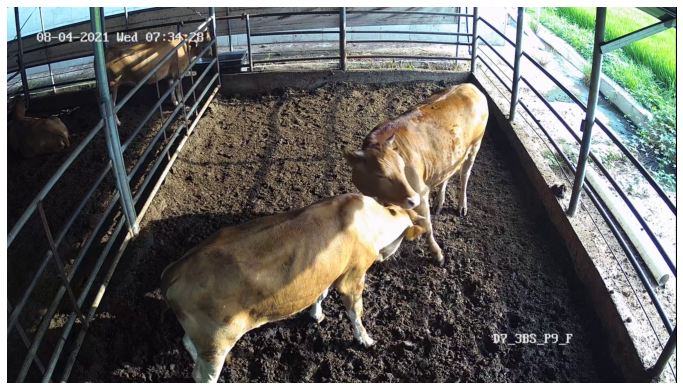

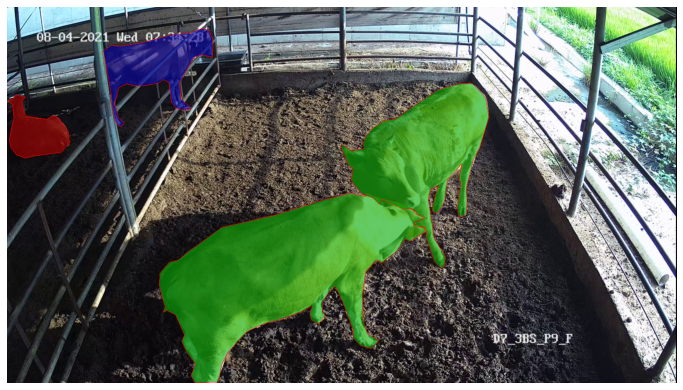

In [10]:
import matplotlib.pyplot as plt
import cv2

# 원본 이미지 시각화 
image_array = cv2.cvtColor(cv2.imread('/content/drive/MyDrive/train_images/train_0001.PNG'), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 14))
plt.imshow(image_array)
plt.axis('off')

# coco segmentation 정보를 기반으로 segmentation 적용한 이미지 시각화 
masked_image = draw_segment(image_array, ann_seg_list, color_list, alpha=0.6)
plt.figure(figsize=(12, 14))
plt.imshow(masked_image)
plt.axis('off')

### Pretrained 모델 다운로드, Config 설정

In [11]:
# pretrained weight 모델을 다운로드 받기 위해서 mmdetection/checkpoints 디렉토리를 만듬. 
!cd mmdetection; mkdir checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists


In [12]:
!wget -O /content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r101_fpn_1x_coco/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth

--2022-01-11 14:22:27--  http://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r101_fpn_1x_coco/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254089599 (242M) [application/octet-stream]
Saving to: ‘/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth’

/content/mmdetectio 100%[===================>] 242.32M  10.1MB/s    in 24s     

2022-01-11 14:22:52 (10.0 MB/s) - ‘/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth’ saved [254089599/254089599]



In [13]:
!ls -lia /content/mmdetection/checkpoints

total 248144
5246599 drwxr-xr-x  2 root root      4096 Jan 11 14:19 .
5242882 drwxr-xr-x 19 root root      4096 Jan 11 14:19 ..
5246600 -rw-r--r--  1 root root 254089599 Nov  2 16:37 mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth


In [114]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmdetection/configs/mask_rcnn/mask_rcnn_r101_fpn_1x_coco.py'
checkpoint_file = '/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth'

In [115]:
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.coco import CocoDataset

@DATASETS.register_module(force=True)
class cowDataset(CocoDataset):
  CLASSES = ('cow','crazycow' )

In [151]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained',
                      checkpoint='torchvision://resnet101')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoi

In [191]:
from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 수정. 
cfg.dataset_type = 'cowDataset'
cfg.data_root = '/content/drive/MyDrive/train_images/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정. 
cfg.data.train.type = 'cowDataset'
cfg.data.train.data_root = '/content/drive/MyDrive/train_images/'
cfg.data.train.ann_file = '/content/drive/MyDrive/train_images/train_answer2.json'
cfg.data.train.img_prefix = 'train'

cfg.data.val.type = 'cowDataset'
cfg.data.val.data_root = '/content/drive/MyDrive/train_images/train_answer2.json'
cfg.data.val.ann_file = '/content/drive/MyDrive/train_images/train_answer2.json'
cfg.data.val.img_prefix = 'val'
 
cfg.data.test.type = 'cowDataset'
cfg.data.test.data_root = '/content/drive/MyDrive/train_images/'
cfg.data.test.ann_file = '/content/drive/MyDrive/train_images/train_answer2.json'
cfg.data.test.img_prefix = 'test'

# class의 갯수 수정. 
cfg.model.roi_head.bbox_head.num_classes = 2
cfg.model.roi_head.mask_head.num_classes = 2

# pretrained 모델
cfg.load_from = '/content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정. 
cfg.work_dir = './tutorial_exps'

# 학습율 변경 환경 파라미터 설정. 
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# CocoDataset의 경우 metric을 bbox로 설정해야 함.(mAP아님. bbox로 설정하면 mAP를 iou threshold를 0.5 ~ 0.95까지 변경하면서 측정)
cfg.evaluation.metric = ['bbox', 'segm']
cfg.evaluation.interval = 12
cfg.checkpoint_config.interval = 12

# epochs 횟수는 36으로 증가 
cfg.runner.max_epochs = 36

# 두번 config를 로드하면 lr_config의 policy가 사라지는 오류로 인하여 설정. 
cfg.lr_config.policy='step'
# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

In [192]:
print(cfg.pretty_text)

model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained',
                      checkpoint='torchvision://resnet101')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoi

### 학습 수행

In [193]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# train용 Dataset 생성. 
datasets = [build_dataset(cfg.data.train)]

loading annotations into memory...
Done (t=1.45s)
creating index...
index created!


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 263, in _feed
    queue_sem.release()
ValueError: semaphore or lock released too many times

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
   

In [194]:
datasets[0]


cowDataset Train dataset with number of images 0, and instance counts: 
+----------+-------+--------------+-------+----------+-------+----------+-------+----------+-------+
| category | count | category     | count | category | count | category | count | category | count |
+----------+-------+--------------+-------+----------+-------+----------+-------+----------+-------+
|          |       |              |       |          |       |          |       |          |       |
| 0 [cow]  | 0     | 1 [crazycow] | 0     |          |       |          |       |          |       |
+----------+-------+--------------+-------+----------+-------+----------+-------+----------+-------+

In [195]:
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
model.CLASSES = datasets[0].CLASSES
print(model.CLASSES)

('cow', 'crazycow')


In [196]:
import os.path as osp
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# epochs는 config의 runner 파라미터로 지정됨. 기본 12회 
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...


2022-01-11 16:41:42,275 - mmdet - INFO - load checkpoint from local path: /content/mmdetection/checkpoints/mask_rcnn_r101_fpn_1x_coco_20200204-1efe0ed5.pth


Done (t=0.33s)
creating index...
index created!


2022-01-11 16:41:42,513 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([3, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([3]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([8, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([8]).
size mismatch for roi_head.mask_head.conv_logits.weight: copying a param with shape torch.Size([80, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for roi_head.mask_head.conv_logits.bias

ValueError: ignored

### 단일 이미지와 Video Inference 수행. 

In [159]:
from mmdet.apis import inference_detector, show_result_pyplot

checkpoint_file = '/content/tutorial_exps/epoch_36.pth'

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_detector(cfg, checkpoint_file, device='cuda:0')

NameError: ignored

In [ ]:
# BGR Image 사용 
#14898532020_ba6199dd22_k.jpg, 16335852991_f55de7958d_k.jpg
img = cv2.imread('/content/balloon/val/16335852991_f55de7958d_k.jpg')
#model_ckpt.cfg = cfg

result = inference_detector(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, score_thr=0.5)

In [ ]:
import numpy as np

labels_to_names_seq =  {1:'cow', 2: 'crazy cow'}
  
colors = list(
    [[0, 255, 0],
     [0, 0, 255],
     [255, 0, 0],
     [0, 255, 255],
     [255, 255, 0],
     [255, 0, 255],
     [80, 70, 180],
     [250, 80, 190],
     [245, 145, 50],
     [70, 150, 250]] )

In [ ]:
# model과 원본 이미지 array, filtering할 기준 class confidence score를 인자로 가지는 inference 시각화용 함수 생성. 
# 이미 inference 시 mask boolean값이 들어오므로 mask_threshold 값을 필요하지 않음. 
def get_detected_img(model, img_array,  score_threshold=0.3, draw_box=True, is_print=True):
  # 인자로 들어온 image_array를 복사. 
  draw_img = img_array.copy()
  bbox_color=(0, 255, 0)
  text_color=(0, 0, 255)

  # model과 image array를 입력 인자로 inference detection 수행하고 결과를 results로 받음. 
  results = inference_detector(model, img_array)
  bbox_results = results[0]
  seg_results = results[1]

  # results 리스트를 loop를 돌면서 개별 2차원 array들을 추출하고 이를 기반으로 이미지 시각화 
  # results 리스트의 위치 index가  Class id. 여기서는 result_ind가 class id
  # 개별 2차원 array에 오브젝트별 좌표와 class confidence score 값을 가짐. 
  for result_ind, bbox_result in enumerate(bbox_results):
    # 개별 2차원 array의 row size가 0 이면 해당 Class id로 값이 없으므로 다음 loop로 진행. 
    if len(bbox_result) == 0:
      continue
    
    mask_array_list = seg_results[result_ind]
    
    # 해당 클래스 별로 Detect된 여러개의 오브젝트 정보가 2차원 array에 담겨 있으며, 이 2차원 array를 row수만큼 iteration해서 개별 오브젝트의 좌표값 추출. 
    for i in range(len(bbox_result)):
      # 좌상단, 우하단 좌표 추출. 
      if bbox_result[i, 4] > score_threshold:
        left = int(bbox_result[i, 0])
        top = int(bbox_result[i, 1])
        right = int(bbox_result[i, 2])
        bottom = int(bbox_result[i, 3])
        caption = "{}: {:.4f}".format(labels_to_names_seq[result_ind], bbox_result[i, 4])
        if draw_box:
          cv2.rectangle(draw_img, (left, top), (right, bottom), color=bbox_color, thickness=2)
          cv2.putText(draw_img, caption, (int(left), int(top - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.37, text_color, 1)
        # masking 시각화 적용. class_mask_array는 image 크기 shape의  True/False값을 가지는 2차원 array
        class_mask_array = mask_array_list[i]
        # 원본 image array에서 mask가 True인 영역만 별도 추출. 
        masked_roi = draw_img[class_mask_array]
        #color를 임의 지정
        #color_index = np.random.randint(0, len(colors)-1)
        # color를 class별로 지정
        color_index = result_ind % len(colors)
        color = colors[color_index]

        # apply_mask()함수를 적용시 수행 시간이 상대적으로 오래 걸림. 
        #draw_img = apply_mask(draw_img, class_mask_array, color, alpha=0.4)
        # 원본 이미지의 masking 될 영역에 mask를 특정 투명 컬러로 적용
        draw_img[class_mask_array] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.6 * masked_roi).astype(np.uint8)
        
        if is_print:
          print(caption)
  
  return draw_img

In [ ]:
import matplotlib.pyplot as plt

img_arr = cv2.imread('/content/balloon/val/16335852991_f55de7958d_k.jpg')
detected_img = get_detected_img(model_ckpt, img_arr,  score_threshold=0.3, draw_box=False, is_print=True)
# detect 입력된 이미지는 bgr임. 이를 최종 출력시 rgb로 변환 
detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(14, 14))
plt.imshow(detected_img)

In [ ]:
# 원본 이미지를 Gray scale로 변환하고, 컬러 기반 instance segmentation을 적용하는 함수
def get_detected_img_n_gray(model, img_array,  score_threshold=0.3, draw_box=True, is_print=True):
  # 인자로 들어온 image_array를 복사. 
  draw_img = img_array.copy()
  bbox_color=(0, 255, 0)
  text_color=(0, 0, 255)

  # model과 image array를 입력 인자로 inference detection 수행하고 결과를 results로 받음. 
  # results는 80개의 2차원 array(shape=(오브젝트갯수, 5))를 가지는 list. 
  results = inference_detector(model, img_array)
  bbox_results = results[0]
  seg_results = results[1]

  # 원본 이미지를 Grayscale로 변환. BGR2GRAY적용시 2차원 array로 변환되므로 다시 GRAY2BGR로 변환하면 3차원이지만, 여전히 Grayscale임. 
  draw_img_gray = cv2.cvtColor(cv2.cvtColor(draw_img, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)
  
  # 80개의 array원소를 가지는 results 리스트를 loop를 돌면서 개별 2차원 array들을 추출하고 이를 기반으로 이미지 시각화 
  # results 리스트의 위치 index가 바로 COCO 매핑된 Class id. 여기서는 result_ind가 class id
  # 개별 2차원 array에 오브젝트별 좌표와 class confidence score 값을 가짐. 
  for result_ind, bbox_result in enumerate(bbox_results):
    # 개별 2차원 array의 row size가 0 이면 해당 Class id로 값이 없으므로 다음 loop로 진행. 
    if len(bbox_result) == 0:
      continue
    
    mask_array_list = seg_results[result_ind]
    
    # 해당 클래스 별로 Detect된 여러개의 오브젝트 정보가 2차원 array에 담겨 있으며, 이 2차원 array를 row수만큼 iteration해서 개별 오브젝트의 좌표값 추출. 
    for i in range(len(bbox_result)):
      # 좌상단, 우하단 좌표 추출. 
      if bbox_result[i, 4] > score_threshold:
        left = int(bbox_result[i, 0])
        top = int(bbox_result[i, 1])
        right = int(bbox_result[i, 2])
        bottom = int(bbox_result[i, 3])
        caption = "{}: {:.4f}".format(labels_to_names_seq[result_ind], bbox_result[i, 4])
        if draw_box:
          cv2.rectangle(draw_img, (left, top), (right, bottom), color=bbox_color, thickness=2)
          cv2.putText(draw_img, caption, (int(left), int(top - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.37, text_color, 1)
        
        
        # masking 시각화 적용. class_mask_array는 image 크기 shape의  True/False값을 가지는 2차원 array
        class_mask_array = mask_array_list[i]
        # 원본 image array에서 mask가 True인 영역만 별도 추출. 색깔을 가지는 풍선 영역 
        masked_roi = draw_img[class_mask_array]
        #color를 임의 지정
        #color_index = np.random.randint(0, len(colors)-1)
        # color를 class별로 지정
        color_index = result_ind % len(colors)
        color = colors[color_index]

        # 원본 이미지가 아닌 Gray scale 이미지 위에 masking 될 영역에 mask를 투명 컬러로 적용
        draw_img_gray[class_mask_array] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.6 * masked_roi).astype(np.uint8)
        
        if is_print:
          print(caption)
  
  return draw_img_gray

In [ ]:

img_arr = cv2.imread('/content/balloon/val/16335852991_f55de7958d_k.jpg')
detected_img = get_detected_img_n_gray(model_ckpt, img_arr,  score_threshold=0.3, draw_box=False, is_print=True)
# detect 입력된 이미지는 bgr임. 이를 최종 출력시 rgb로 변환 
detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(14, 14))
plt.imshow(detected_img)

In [ ]:
!mkdir ./data
!wget -O /content/data/balloon_dog02.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/balloon_dog02.mp4?raw=true

In [ ]:
import time

def do_detected_video(model, input_path, output_path, score_threshold, do_print=True):
    
    cap = cv2.VideoCapture(input_path)

    codec = cv2.VideoWriter_fourcc(*'XVID')

    vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_fps = cap.get(cv2.CAP_PROP_FPS)

    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt)
    btime = time.time()
    while True:
        hasFrame, img_frame = cap.read()
        if not hasFrame:
            print('더 이상 처리할 frame이 없습니다.')
            break
        stime = time.time()
        # Detect된 segmentation 영역만 컬러 처리하고, 나머지 영역은 Grayscale 처리.
        img_frame = get_detected_img_n_gray(model, img_frame, score_threshold=score_threshold, draw_box=False, is_print=False)
        if do_print:
          print('frame별 detection 수행 시간:', round(time.time() - stime, 4))
        vid_writer.write(img_frame)
    # end of while loop

    vid_writer.release()
    cap.release()

    print('최종 detection 완료 수행 시간:', round(time.time() - btime, 4))

In [ ]:
do_detected_video(model_ckpt, '/content/data/balloon_dog02.mp4', '/content/data/balloon_dog02_out.avi', score_threshold=0.4, do_print=True)